# autoTS: Spectral Analysis template

This notebook describes a workflow for spectral analysis. It can be used as a template for similar analysis. Each cell represents a worflow component (input not written to disk). 

**Table of contents**
* Generating Data
* Pre-processing
    * Standardization
    * Detrend
    * Detect outliers
    * Remove outliers
    * Hypothesize over missing values
* Analysis
    * Spectral analysis
    * Significance testing 
* Visualization
    * Periodogram
    
Functions are available through the [Pyleoclim package](https://github.com/LinkedEarth/Pyleoclim_util/tree/Development) on the development branch.

In [3]:
import pyleoclim as pyleo

Functions to handle writing in and out of "components"

In [117]:
import json

def transform(obj_dict):
    for k in obj_dict.keys():
        if isinstance(obj_dict[k],(np.ndarray)):
            obj_dict[k] = obj_dict[k].tolist()
        elif isinstance(obj_dict[k],(pyleo.Series,pyleo.PSD)):
            obj_dict[k]=PyleoObj_to_json(obj_dict[k],dict_return=True)
        elif isinstance(obj_dict[k],pyleo.MultiplePSD):
            obj_dict[k]=PyleoObj_to_json(obj_dict[k],dict_return=True)
            c=[]
            idx = np.arange(0,len(obj_dict[k]['psd_list']),1).tolist()
            for item in idx:
                PSD_dict=PyleoObj_to_json(obj_dict[k]['psd_list'][item],dict_return=True)
                c.append(PSD_dict)
            obj_dict[k]['psd_list']=c            
        elif isinstance(obj_dict[k],(dict)):
            obj_dict[k]=transform(obj_dict[k])
    return obj_dict


def list_to_array(obj_dict):
    for k in obj_dict:
        if type(obj_dict[k])is dict:
            obj_dict[k]=list_to_array(obj_dict[k])
        elif type(obj_dict[k]) is list:
            obj_dict[k]=np.array(obj_dict[k])
        else:
            obj_dict[k]=obj_dict[k]
    return obj_dict

def PyleoObj_to_json(PyleoObj,filename='trial',dict_return=False):
    obj_dict = PyleoObj.__dict__
    obj_dict = transform(obj_dict)
    if dict_return == False:
        with open('./IntermediateOutputs/'+filename+'.json','w') as f:
            json.dump(obj_dict, f)
            f.close()
    elif dict_return == True:
        return  obj_dict

def json_to_Series(filename):
    with  open('./IntermediateOutputs/'+filename+'.json','r') as f:
        t = json.load(f)
    ts = pyleo.Series(time=np.array(t['time']),
                     value=np.array(t['value']),
                     time_name=t['time_name'],
                     time_unit=t['time_unit'],
                     value_name=t['value_name'],
                     value_unit=t['value_unit'],
                     label=t['label']) 
    return ts

def PSD_to_MultiplePSD(series_list):
    idx = np.arange(0,len(series_list),1).tolist()
    d=[]
    for item in idx:
        t=series_list[item]
        PSD_obj=pyleo.PSD(frequency=np.array(t['frequency']),
                        amplitude=np.array(t['amplitude']),
                        label=t['label'],
                        timeseries = t['timeseries'],
                        spec_method = t['spec_method'],
                        spec_args =  t['spec_args'],
                        signif_qs = t['signif_qs'],
                    signif_method = t['signif_method'])
        d.append(PSD_obj)
    MPSD=pyleo.MultiplePSD(psd_list=d)
    return MPSD
        

def json_to_PSD(filename):
    with  open('./IntermediateOutputs/'+filename+'.json','r') as f:
        t = json.load(f)
    t = list_to_array(t)
    
    #Deal with significance testing 
    if type(t['signif_qs']) is dict:
        c = PSD_to_MultiplePSD(t['signif_qs']['psd_list'])
    else:
        c = t['signif_qs']
        
    psd = pyleo.PSD(frequency=np.array(t['frequency']),
                    amplitude=np.array(t['amplitude']),
                    label=t['label'],
                    timeseries = pyleo.Series(time=np.array(t['timeseries']['time']),
                                             value=np.array(t['timeseries']['value']),
                                             time_name=t['timeseries']['time_name'],
                                             time_unit=t['timeseries']['time_unit'],
                                             value_name=t['timeseries']['value_name'],
                                             value_unit=t['timeseries']['value_unit'],
                                             label=t['timeseries']['label']),
                    spec_method = t['spec_method'],
                    spec_args =  t['spec_args'],
                    signif_qs = c,
                    signif_method = t['signif_method'])
    
    return  psd

## Data Generation

Here,we use synthetic timeseries for demonstration purposes. 

Pyleoclim is being extended to handle LiPD files directly. For other types of data, Pyleoclim's basic object is Series, which will need to be created as a first step.

### Step 1: Generate a signal with trend, noise and missing values

This step would be replaced by opening dataset.

Text(0, 0.5, 'Value')

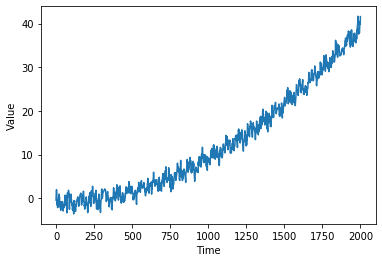

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add outliers

#outliers_start = np.mean(signal)+5*np.std(signal)
#outliers_end = np.mean(signal)+7*np.std(signal)
#outlier_values = np.arange(outliers_start,outliers_end,0.1)
#index = np.random.randint(0,len(signal),6)
#signal_out = signal
#for i,ind in enumerate(index):
#    signal_out[ind] = outlier_values[i]

# Add a non-linear trend
slope = 1e-5
intercept = -1
nonlinear_trend = slope*time**2 + intercept
signal_trend = signal + nonlinear_trend
#signal_trend = signal_out + nonlinear_trend

#Add white noise
sig_var = np.var(signal)
noise_var = sig_var / 2 #signal is twice the size of noise
white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
signal_noise = signal_trend + white_noise

#Remove data points
del_percent = 0.4
n_del = int(del_percent*np.size(time))
deleted_idx = np.random.choice(range(np.size(time)), n_del, replace=False)
time_unevenly =  np.delete(time, deleted_idx)
signal_unevenly =  np.delete(signal_noise, deleted_idx)


#Plot
plt.plot(time_unevenly,signal_unevenly)
plt.xlabel('Time')
plt.ylabel('Value')

### Step 2: Create a series object for Pyleoclim

Create the time series object and write it as an intermediate output in JSON. 

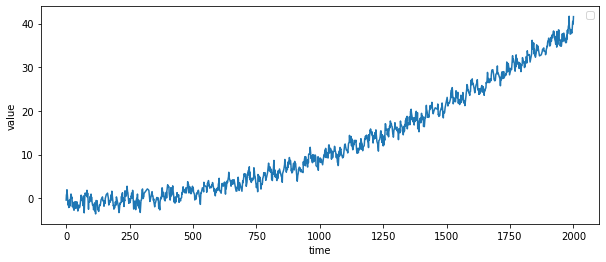

In [6]:
import json

ts = pyleo.Series(time=time_unevenly,value=signal_unevenly)
PyleoObj_to_json(ts,'ts')

fig,ax = ts.plot()

## Preprocessing

### Standarize

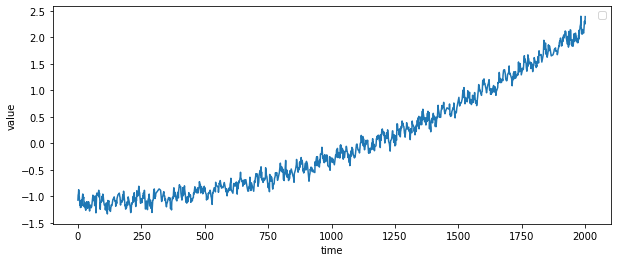

In [7]:
ts = json_to_Series('ts') #load JSON
ts_std = ts.standardize()
PyleoObj_to_json(ts_std,'ts_std') #write to JSON
fig,ax = ts_std.plot()

### Detrend

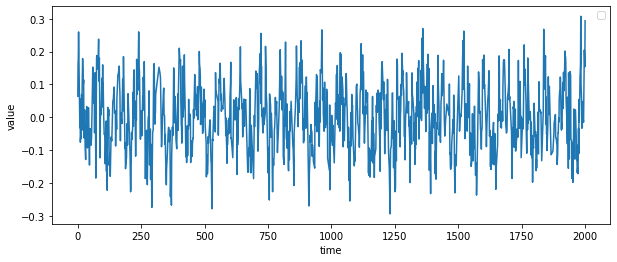

In [8]:
ts_std = json_to_Series('ts_std') #load JSON
ts_detrended = ts_std.detrend(method='emd')
PyleoObj_to_json(ts_detrended,'ts_detrended') #write to JSON
fig,ax = ts_detrended.plot()

### Detect outliers and remove outliers

Based on the detected outliers, may need to remove them prior to analysis. 

In this case, the if/else could happen within the component: do nothing on else but return a similar object to be used by the next component.

In [9]:
ts_detrended = json_to_Series('ts_detrended') #load JSON
is_outlier = ts_detrended.detect_outliers()
if len(np.where(is_outlier==True))>0:
    ts_outliers = ts_detrended.remove_outliers()
    PyleoObj_to_json(ts_outliers,'ts_outliers') #write to JSON
else:
    PyleoObj_to_json(ts_detrended,'ts_outliers') #write to JSON

### Interpolation

This example uses a linear interpolation, other methods to achieve an evenly-spaced time series are spline interpolation, binning, and singular spectrum analysis. All methods could be equally valid and should be explored.

**Rule**: if the method spectral analysis is 'Lomb-Scargle' or 'WWZ', this step should be skipped (or same timeseries returned); else, this step is necessary. 

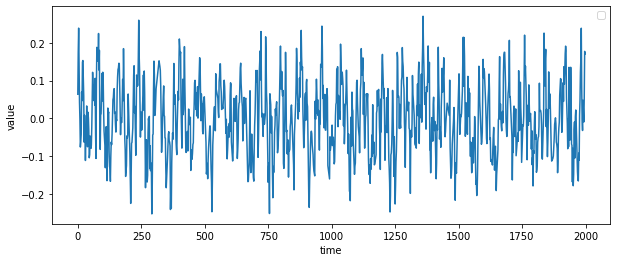

In [10]:
ts_outliers = json_to_Series('ts_outliers') #load JSON
ts_interp = ts_outliers.interp(method='linear')
PyleoObj_to_json(ts_interp,'ts_interp') #write to JSON
fig,ax = ts_interp.plot()

### Analysis

### Spectral Analysis
#### WWZ

This method doesn't require require evenly-spaced data in time, and therefore  uses the detrended time series.

In [11]:
%%time
ts_detrended = json_to_Series('ts_detrended') #load JSON
psd_wwz = ts_detrended.spectral(settings={'method': 'Kirchner_f2py'})
PyleoObj_to_json(psd_wwz,'psd_wwz')

CPU times: user 18.6 s, sys: 37.7 ms, total: 18.6 s
Wall time: 3.93 s


This method requires evenly-spaced data in time, and therefore uses the interpreted time series.

In [12]:
ts_interp = json_to_Series('ts_interp') #load JSON
psd_mtm = ts_interp.spectral(method='mtm')
PyleoObj_to_json(psd_mtm,'psd_mtm')

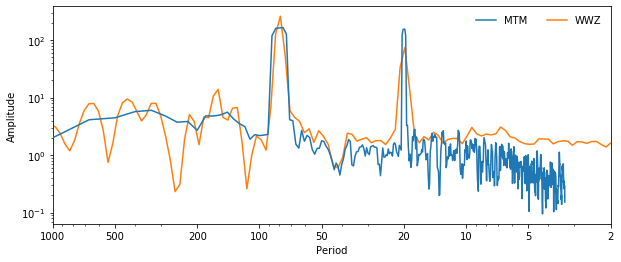

In [13]:
fig,ax = psd_mtm.plot(label='MTM', mute=True, zorder=99)
ax =  psd_wwz.plot(label='WWZ',ax=ax, lgd_kwargs={'ncol': 2})

### Significance testing

The idea behind significance testing is to create surrogate timeseries that could mimic an expected process  in the system (eg. AR1) and test whether the observed peaks could be explained by chance. 

In [79]:
psd_mtm = json_to_PSD('psd_mtm')
psd_mtm_signif = psd_mtm.signif_test(qs=[0.95])
PyleoObj_to_json(psd_mtm_signif,filename='psd_mtm_signif')

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [00:06<00:00, 28.85it/s]


In [75]:
psd_wwz = json_to_PSD('psd_wwz')
psd_wwz_signif = psd_wwz.signif_test(qs=[0.95])
PyleoObj_to_json(psd_wwz_signif,'psd_wwz_signif')

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [08:49<00:00,  2.80s/it]


## Visualization

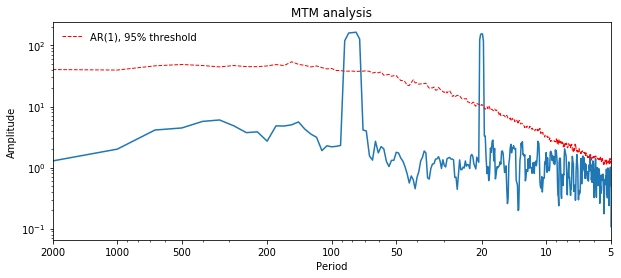

In [118]:
psd_mtm_signif = json_to_PSD('psd_mtm_signif')
fig, ax = psd_mtm_signif.plot(title='MTM analysis')

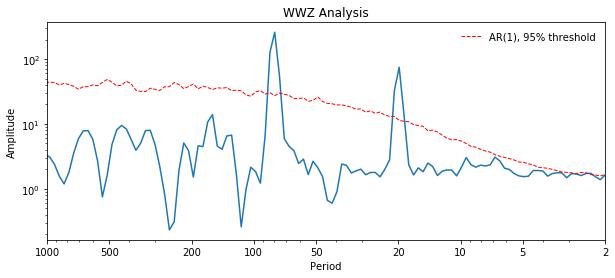

In [119]:
psd_wwz_signif = json_to_PSD('psd_wwz_signif')
fig, ax = psd_wwz_signif.plot(title='WWZ Analysis')